In [350]:
# Goal: Data preprocessing, NLP, topic models with LDA (MALLET, Gensim), visualizaion (preliminary)
# Result: implementations of topic models with high coherence scores from each library
# Output: pyLDAvis, wordcloud, csvs (document-topic, topic-document...)
# Resource: https://www.machinelearningplus.com/nlp/topic-modeling
# TO DO: save corpus, dictionary for reuse

# Load helper libraries
import re
from pprint import pprint
import pandas as pd
import numpy as np

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Enable Gensim logging and warnings
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Text pre-processing model (lemmatization) from spacy (en) and nltk
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn
import wordcloud
#import sklearn
#import bokeh

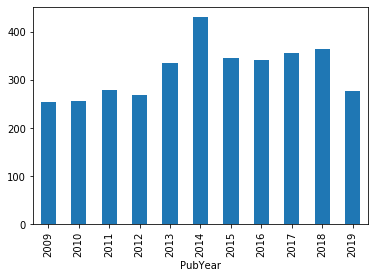

In [97]:
# DATA Read in pubs from csv; report distribution across publication years
pubs = pd.read_csv("ERI-publications-2009-2019.csv")
len(pubs)
pubs.head()
pubs.groupby(['PubYear']).size().plot(kind='bar')
#print(pubs.groupby(['PubYear']).size())

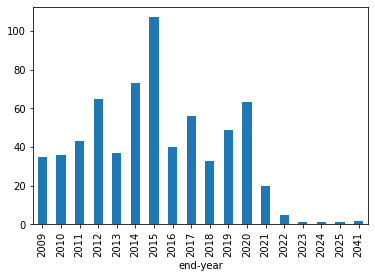

In [92]:
# DATA Read in projects from csv; report distribution across start and end years
proj = pd.read_csv("ERI-projects-2009-2019.csv")
len(proj)
proj.head()
#proj.groupby(['start-year']).size().plot(kind='bar')
proj.groupby(['end-year']).size().plot(kind='bar')
#print(proj.groupby(['end-year']).size())

In [76]:
# DATA Read in docs (corpus) from csv; report length of abstract text
docs = pd.read_csv("ERI-combined-2009-2019.csv")
len(docs)

# Concatenate title and abstract to new column for topic model
docs['combined'] = docs['title'].astype(str) + ' ' + docs['abstract'].astype(str)
docs.head()

# Calculate lengths of combined title and abstract; add columns to dataframe for length of abstracts
docs['title_len'] = docs['title'].apply(len)
docs['abstract_len'] = docs['abstract'].apply(len)
docs['combined_len'] = docs['combined'].apply(len)
docs.head()

# Calculate summary statistics for combined title and abstract lengths to determine text suitability
docs.combined_len.describe()

count    3770.000000
mean     1678.432626
std       687.609548
min       128.000000
25%      1247.000000
50%      1630.000000
75%      1993.000000
max      7083.000000
Name: combined_len, dtype: float64

In [108]:
# DATA Title and abstract to list, removing new line characters, quotations
#docs.head()
data = docs['combined'].values.tolist()
data = [re.sub('\s+', ' ', sent) for sent in data] #remove new line characters
data = [re.sub("\'", "", sent) for sent in data] #remove single quotes
pprint(data[:1])

['Streams and Urbanization Urbanization encompasses a diverse array of '
 'watershed alterations that influence the physical, chemical, and biological '
 'characteristics of streams. In this chapter, we summarize lessons learned '
 'from the last half century of research on urban streams and provide a '
 'critique of various mitigation strategies, including recent approaches that '
 'explicitly address geomorphic processes. We focus first on the abiotic '
 'conditions (primarily hydrologic and geomorphic) and their changes in '
 'streams that accompany urbanization, recognizing that these changes may vary '
 'with geomorphic context and climatic region. We then discuss technical '
 'approaches and limitations to (1) mitigating water-quantity and '
 'water-quality degradation through site design, riparian protection, and '
 'structural stormwater-management strategies; and (2) restoring urban streams '
 'in those watersheds where the economic, social, and political contexts can '
 'supp

In [100]:
# NLP Load stopwords from NLTK, extend default list with custom stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['data', 'study', 'project', 'research', 'collaborative'])

In [155]:
# NLP Tokenize each sentence into a list of lowercase words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True remove punctuation

data_words = list(sent_to_words(data))

print(data_words[:1])

[['streams', 'and', 'urbanization', 'urbanization', 'encompasses', 'diverse', 'array', 'of', 'watershed', 'alterations', 'that', 'influence', 'the', 'physical', 'chemical', 'and', 'biological', 'characteristics', 'of', 'streams', 'in', 'this', 'chapter', 'we', 'summarize', 'lessons', 'learned', 'from', 'the', 'last', 'half', 'century', 'of', 'research', 'on', 'urban', 'streams', 'and', 'provide', 'critique', 'of', 'various', 'mitigation', 'strategies', 'including', 'recent', 'approaches', 'that', 'explicitly', 'address', 'geomorphic', 'processes', 'we', 'focus', 'first', 'on', 'the', 'abiotic', 'conditions', 'primarily', 'hydrologic', 'and', 'geomorphic', 'and', 'their', 'changes', 'in', 'streams', 'that', 'accompany', 'urbanization', 'recognizing', 'that', 'these', 'changes', 'may', 'vary', 'with', 'geomorphic', 'context', 'and', 'climatic', 'region', 'we', 'then', 'discuss', 'technical', 'approaches', 'and', 'limitations', 'to', 'mitigating', 'water', 'quantity', 'and', 'water', 'qua

In [137]:
# NLP Bigram and trigram models (words frequently occurring together in the doc)
bigram = gensim.models.Phrases(data_words, min_count=3, threshold=80) # higher threshold fewer phrases
trigram = gensim.models.Phrases(bigram[data_words], threshold=80)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See bigram example (given a specific record)
print(trigram_mod[bigram_mod[data_words[1]]])

['evidence', 'for', 'widespread', 'creep', 'on', 'the', 'flanks', 'of', 'the', 'sea', 'of', 'marmara', 'transform', 'basin', 'from', 'marine', 'geophysical', 'data', 'wave', 'fields', 'have', 'long', 'been', 'recognized', 'in', 'marine', 'sediments', 'on', 'the', 'flanks', 'of', 'basins', 'and', 'oceans', 'in', 'both', 'tectonically_active', 'and', 'inactive', 'environments', 'the', 'origin', 'of', 'waves', 'hereafter', 'called', 'undulations', 'is', 'controversial', 'competing', 'models', 'ascribe', 'them', 'to', 'depositional', 'processes', 'gravity', 'driven', 'downslope', 'creep', 'or', 'collapse', 'and', 'or', 'tectonic', 'shortening', 'here', 'we', 'analyze', 'pervasive', 'undulation', 'fields', 'identified', 'in', 'swath', 'bathymetry', 'and', 'new', 'high', 'resolution', 'multichannel_seismic', 'mcs', 'reflection', 'data', 'from', 'the', 'sea', 'of', 'marmara', 'turkey', 'although', 'they', 'exhibit', 'some', 'of', 'the', 'classical', 'features', 'of', 'sediment', 'waves', 'the

In [138]:
# NLP Define functions for stopwords, bigrams, trigrams, and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [158]:
# NLP Remove stopwords, make bigrams, make trigrams, and lemmatize
data_words_nostops = remove_stopwords(data_words) # stop words
data_words_bigrams = make_bigrams(data_words_nostops) # bigrams
data_words_trigrams = make_trigrams(data_words_bigrams) # trigrams

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['stream', 'urbanization', 'urbanization', 'encompass', 'diverse', 'array', 'watershed', 'alteration', 'influence', 'physical', 'chemical', 'biological', 'characteristic', 'stream', 'chapter', 'summarize', 'lessons_learn', 'last', 'half', 'century', 'urban', 'stream', 'provide', 'critique', 'various', 'mitigation', 'strategy', 'include', 'recent', 'approach', 'explicitly', 'address', 'geomorphic', 'process', 'focus', 'first', 'abiotic', 'condition', 'primarily', 'hydrologic', 'geomorphic', 'change', 'stream', 'accompany', 'urbanization', 'recognize', 'change', 'may', 'vary', 'geomorphic', 'context', 'climatic', 'region', 'discuss', 'technical', 'approach', 'limitation', 'mitigate', 'water', 'quantity', 'water', 'quality', 'degradation', 'site', 'design', 'riparian', 'protection', 'structural', 'stormwater', 'management', 'strategy', 'restore', 'urban', 'stream', 'watershed', 'economic', 'social', 'political', 'context', 'support', 'activity']]


In [163]:
# NLP Create dictionary and corpus for topic modeling
# Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View corpus based on term-frequency
#print(corpus[:1])
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

# Save dictionary and corpus for future use - optional
#import pickle
#pickle.dump(corpus, open('corpus.pkl', 'wb'))
#id2word.save('dictionary.gensim')

[[('abiotic', 1),
  ('accompany', 1),
  ('activity', 1),
  ('address', 1),
  ('alteration', 1),
  ('approach', 2),
  ('array', 1),
  ('biological', 1),
  ('century', 1),
  ('change', 2),
  ('chapter', 1),
  ('characteristic', 1),
  ('chemical', 1),
  ('climatic', 1),
  ('condition', 1),
  ('context', 2),
  ('critique', 1),
  ('degradation', 1),
  ('design', 1),
  ('discuss', 1),
  ('diverse', 1),
  ('economic', 1),
  ('encompass', 1),
  ('explicitly', 1),
  ('first', 1),
  ('focus', 1),
  ('geomorphic', 3),
  ('half', 1),
  ('hydrologic', 1),
  ('include', 1),
  ('influence', 1),
  ('last', 1),
  ('lessons_learn', 1),
  ('limitation', 1),
  ('management', 1),
  ('may', 1),
  ('mitigate', 1),
  ('mitigation', 1),
  ('physical', 1),
  ('political', 1),
  ('primarily', 1),
  ('process', 1),
  ('protection', 1),
  ('provide', 1),
  ('quality', 1),
  ('quantity', 1),
  ('recent', 1),
  ('recognize', 1),
  ('region', 1),
  ('restore', 1),
  ('riparian', 1),
  ('site', 1),
  ('social', 1),
  

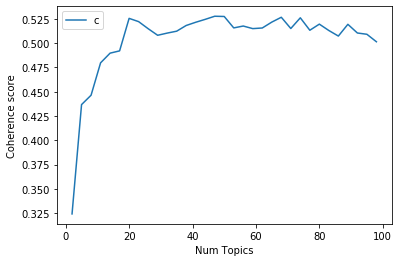

In [164]:
# TOPIC MODELING (LDA) - MALLET, Find optimal number of topics for LDA (up to limit) 
# TO DO: experiment with optimize interval values (10)
# Approach: build many LDA models with different topic numbers (k); find the one with the highest coherence value
# Goal: choose an inflection point (k) that marks the end of a rapid growth of topic coherence

mallet_path = 'mallet-2.0.8/bin/mallet' # path to Mallet file in same directory
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, random_seed=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Can take a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=100, step=3)

# Show graph
limit=100; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [165]:
# TOPIC MODELING (LDA) - MALLET, Print the coherence scores from the previous run; select highest score (47 topics)
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3243
Num Topics = 5  has Coherence Value of 0.4368
Num Topics = 8  has Coherence Value of 0.4465
Num Topics = 11  has Coherence Value of 0.4798
Num Topics = 14  has Coherence Value of 0.4898
Num Topics = 17  has Coherence Value of 0.4921
Num Topics = 20  has Coherence Value of 0.5256
Num Topics = 23  has Coherence Value of 0.5222
Num Topics = 26  has Coherence Value of 0.5149
Num Topics = 29  has Coherence Value of 0.5082
Num Topics = 32  has Coherence Value of 0.5104
Num Topics = 35  has Coherence Value of 0.5124
Num Topics = 38  has Coherence Value of 0.5182
Num Topics = 41  has Coherence Value of 0.5215
Num Topics = 44  has Coherence Value of 0.5245
Num Topics = 47  has Coherence Value of 0.5277
Num Topics = 50  has Coherence Value of 0.5275
Num Topics = 53  has Coherence Value of 0.5157
Num Topics = 56  has Coherence Value of 0.5177
Num Topics = 59  has Coherence Value of 0.515
Num Topics = 62  has Coherence Value of 0.5157
Num Topics = 65  

In [404]:
# TOPIC MODELING (LDA) - MALLET, Build models with high coherence scores (47 topics; 20 topics)
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                             corpus=corpus, 
                                             id2word=id2word, 
                                             num_topics=47,
                                             #num_topics=20,
                                             #optimize_interval=10, #TO DO: experiment with hyperparameter
                                             random_seed=1)

# Show topics - optional
pprint(ldamallet.show_topics(formatted=False))

# Compute coherence score, verify that it is the same as in the previous run (higher is better)
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(33,
  [('estimate', 0.06442737590278574),
   ('emission', 0.04814857273873668),
   ('source', 0.03485039550613321),
   ('high', 0.032557606328098135),
   ('methane', 0.022240055026940275),
   ('pressure', 0.021666857732431502),
   ('measurement', 0.018915510718789406),
   ('concentration', 0.017425197753066606),
   ('derive', 0.017310558294164852),
   ('increase', 0.015934884787343805)]),
 (43,
  [('program', 0.024736521208953925),
   ('include', 0.020817002003309815),
   ('work', 0.01837819005313126),
   ('ucsb', 0.017942687919170804),
   ('collection', 0.015068373835031791),
   ('goal', 0.01437157042069506),
   ('provide', 0.011323055482971866),
   ('develop', 0.010713352495427228),
   ('year', 0.010626252068635137),
   ('support', 0.010016549081090497)]),
 (38,
  [('relationship', 0.052808772604848016),
   ('influence', 0.04232397075798384),
   ('factor', 0.04222777991535206),
   ('structure', 0.04184301654482493),
   ('variation', 0.030781069642170065),
   ('result', 0.0295305886

In [405]:
# VISUALIZATION (LDA), MALLET - Convert the class of the Mallet model into a LdaModel, show in pyLDAvis
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
#pyLDAvis.save_html(vis, 'lda-mallet-20.html') #saves pyLDAvis graphs as standalone webpage
vis

/Users/saralafia/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/saralafia/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/saralafia/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/Users/saralafia/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
37    -0.200900  0.107185       1        1  2.591521
19     0.055895 -0.249393       2        1  2.453610
26    -0.122156  0.073416       3        1  2.450314
35     0.093358 -0.027069       4        1  2.444248
25     0.139997  0.097054       5        1  2.425103
0     -0.110048 -0.004655       6        1  2.392604
40     0.175352 -0.079728       7        1  2.387454
13     0.210184  0.133589       8        1  2.351025
7     -0.181165  0.096142       9        1  2.334782
42     0.000291 -0.158237      10        1  2.326006
43     0.142601  0.086646      11        1  2.305937
46     0.151442  0.155939      12        1  2.286959
39     0.145992 -0.077432      13        1  2.285340
14    -0.040926 -0.173090      14        1  2.280500
30    -0.075686 -0.028702      15        1  2.255868
3      0.014770 -0.193575      16        1  2.245541
2     -0.033766  0.036210      17        1  2.234573
41    -0.181371  0.037253      18        1  2.231727
5     -0.200813  0.127808      19        1  2.183639
38    -0.048368 -0.074128      20        1  2.177437
20    -0.097564 -0.191842      21        1  2.176023
4     -0.068015  0.034763      22        1  2.171239
15    -0.001137 -0.108857      23        1  2.156875
11    -0.088037  0.016512      24        1  2.094712
18     0.124014  0.152408      25        1  2.080625
12    -0.026257  0.047090      26        1  2.075995
45    -0.046585  0.096883      27        1  2.074555
16    -0.020982 -0.060806      28        1  2.069248
9     -0.186325  0.070865      29        1  2.061972
44     0.157853 -0.096829      30        1  2.045407
23     0.160803  0.050571      31        1  2.038319
28     0.153175  0.169990      32        1  2.037348
17    -0.069903  0.091791      33        1  2.019389
36     0.015291 -0.117419      34        1  2.018077
1     -0.013175 -0.032955      35        1  2.011128
6     -0.057451 -0.023735      36        1  2.004231
29     0.070816 -0.137284      37        1  1.992150
33    -0.020339  0.015613      38        1  1.876320
31    -0.102280  0.005423      39        1  1.864982
22    -0.007589  0.053114      40        1  1.860130
32     0.006356 -0.136311      41        1  1.855315
24     0.135511  0.069266      42        1  1.849407
8     -0.025459  0.015041      43        1  1.823001
21     0.008358  0.126688      44        1  1.821633
27     0.062038 -0.074556      45        1  1.813140
34     0.108381  0.099574      46        1  1.734792
10    -0.106178 -0.020232      47        1  1.729798, topic_info=      Category         Freq            Term        Total  loglift  logprob
121    Default  4392.000000           model  4392.000000  30.0000  30.0000
64     Default  2862.000000           water  2862.000000  29.0000  29.0000
109    Default  2866.000000            high  2866.000000  28.0000  28.0000
9      Default  2412.000000          change  2412.000000  27.0000  27.0000
112    Default  2195.000000        increase  2195.000000  26.0000  26.0000
911    Default  1370.000000            soil  1370.000000  25.0000  25.0000
784    Default  1622.000000           scale  1622.000000  24.0000  24.0000
138    Default  1308.000000         spatial  1308.000000  23.0000  23.0000
228    Default  1703.000000          specie  1703.000000  22.0000  22.0000
337    Default  1407.000000         climate  1407.000000  21.0000  21.0000
581    Default  1492.000000             low  1492.000000  20.0000  20.0000
51     Default  1057.000000            site  1057.000000  19.0000  19.0000
1220   Default  1138.000000     temperature  1138.000000  18.0000  18.0000
41     Default  1651.000000         process  1651.000000  17.0000  17.0000
262    Default  1666.000000          effect  1666.000000  16.0000  16.0000
5      Default  1056.000000        approach  1056.000000  15.0000  15.0000
713    Default   881.000000            snow   881.000000  14.0000  14.0000
643    Def

In [179]:
# TOPIC MODELING (LDA) - MALLET, Dominant topic for each document to csv
def format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get dominant topic for each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the dominant topic, percent contribution, and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)
#df_dominant_topic.to_csv('LDA-47-top-doc.csv') #save out to csv

In [181]:
# TOPIC MODELING (LDA) - MALLET, Most representative document for each topic to csv
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet
#sent_topics_sorteddf_mallet.to_csv('LDA-47-rep-doc.csv') #save out to csv

In [182]:
# TOPIC MODELING (LDA) - MALLET, Topic distribution across documents to csv
# Number of documents for each topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of documents for each topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic number and keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate columns
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics
#df_dominant_topics.to_csv('LDA-47-top-dist.csv') #save out to csv

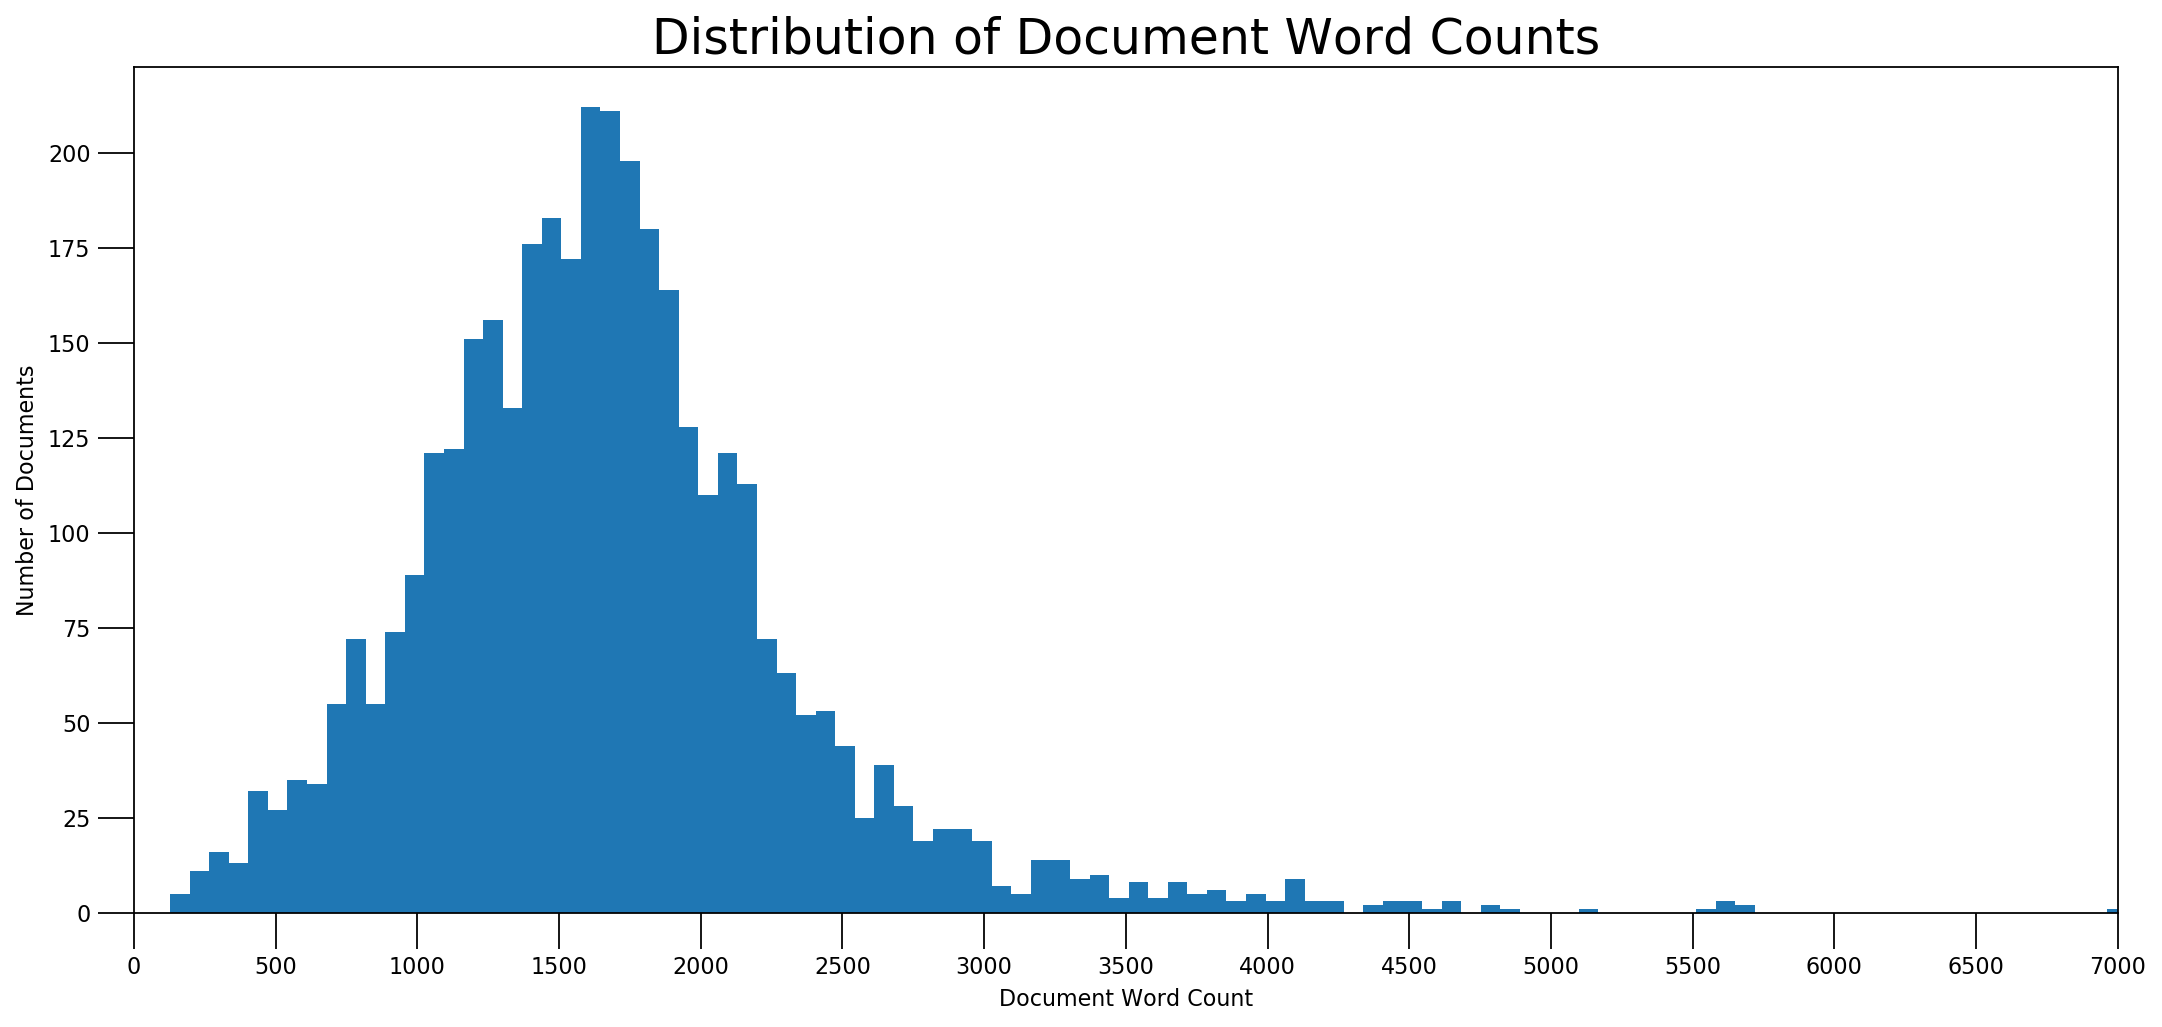

In [214]:
# VISUALIZATION (LDA), MALLET - Frequency distribution of word counts in documents
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 100)
# plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
# plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
# plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
# plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
# plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 7000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,7000,15))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

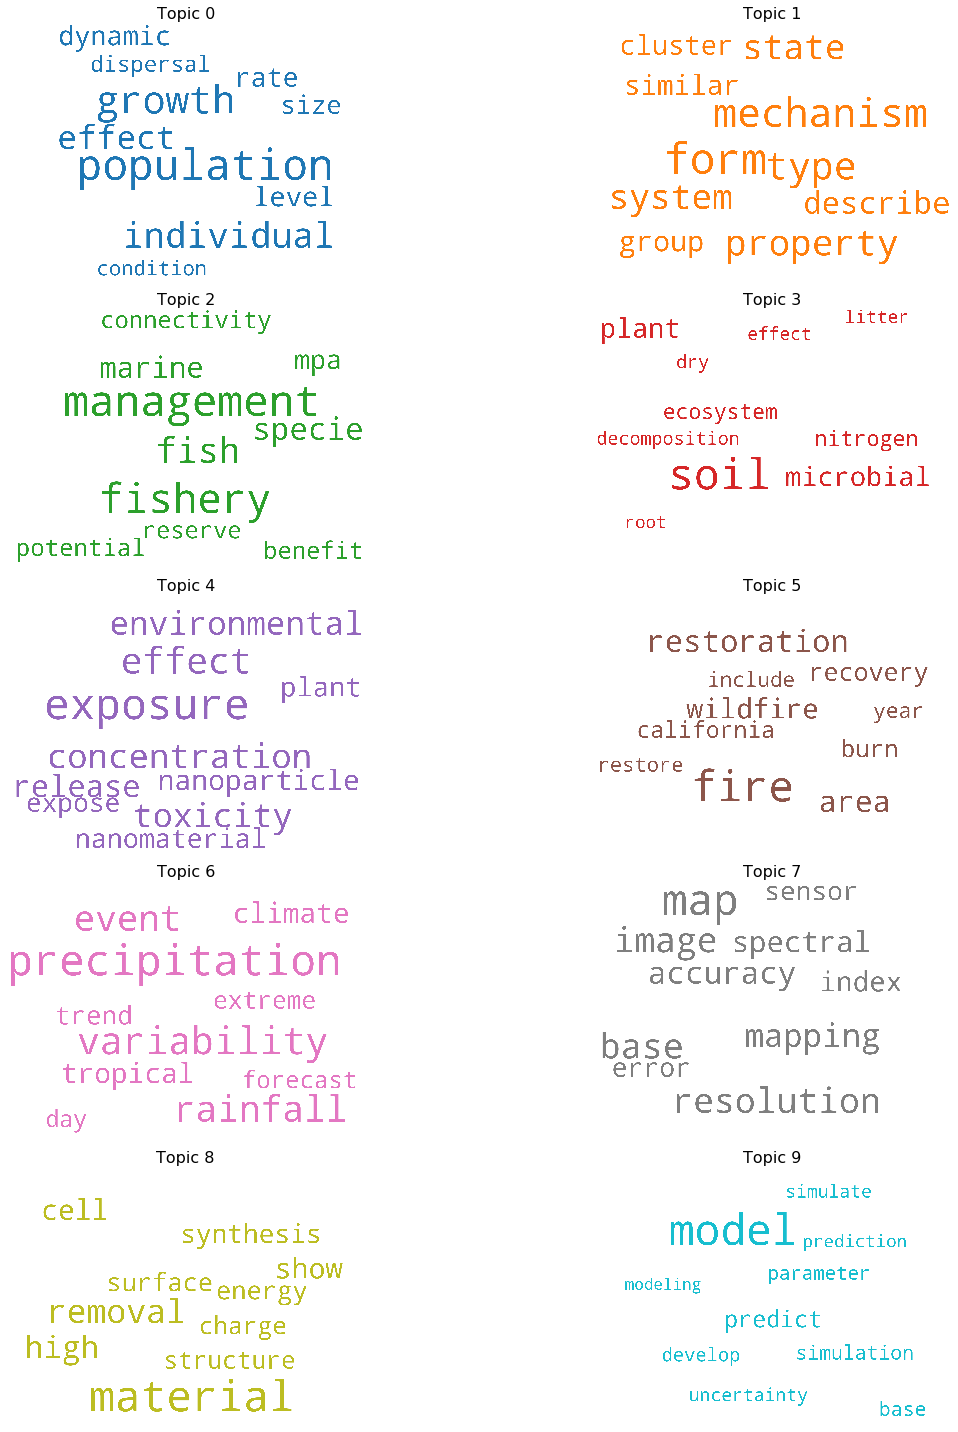

In [334]:
# VISUALIZATION (LDA), MALLET - Wordcloud of top N words in each topic
# TO DO: figure out why different 10 topics used when re-run
# TO DO: visualize all topic wordclouds (if useful)
# TO DO: fix dictionary format and topic numbers
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamallet.show_topics(formatted=False) #num_topics=-1 shows all; if left empty, pulls X most significant topics
#print(topics) #see tuple structure of topics [(topic), [('keyword', 'weight'), ('keyword', 'weight')...]]

fig, axes = plt.subplots(5, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
#    print(topic_words)
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16)) #topic numbers are incorrect (instead check print(topics) and print(topic_words))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
#plt.savefig('LDA-mallet-47-word-clouds-V1.png') #exports graphic

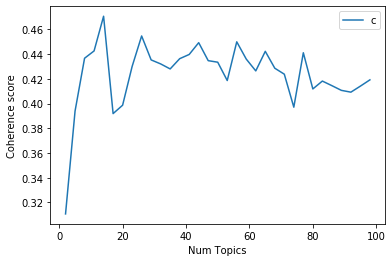

In [357]:
# TOPIC MODELING (LDA) - Gensim, Find optimal number of topics for LDA (up to limit) 
# Approach: build many LDA models with different topic numbers (k); find the one with the highest coherence value
# Goal: choose an inflection point (k) that marks the end of a rapid growth of topic coherence

def compute_coherence_values(corpus, dictionary, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           #alpha=0.01,
                                           #eta=0.1,
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Can take a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=100, step=3)

# Show graph
limit=100; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [358]:
# TOPIC MODELING (LDA) - Gensim, Print the coherence scores from the previous run; select highest score (59 topics)
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3108
Num Topics = 5  has Coherence Value of 0.394
Num Topics = 8  has Coherence Value of 0.4367
Num Topics = 11  has Coherence Value of 0.4426
Num Topics = 14  has Coherence Value of 0.4707
Num Topics = 17  has Coherence Value of 0.3919
Num Topics = 20  has Coherence Value of 0.3987
Num Topics = 23  has Coherence Value of 0.4301
Num Topics = 26  has Coherence Value of 0.4547
Num Topics = 29  has Coherence Value of 0.4354
Num Topics = 32  has Coherence Value of 0.4321
Num Topics = 35  has Coherence Value of 0.4281
Num Topics = 38  has Coherence Value of 0.4364
Num Topics = 41  has Coherence Value of 0.4398
Num Topics = 44  has Coherence Value of 0.4493
Num Topics = 47  has Coherence Value of 0.4348
Num Topics = 50  has Coherence Value of 0.4335
Num Topics = 53  has Coherence Value of 0.4187
Num Topics = 56  has Coherence Value of 0.45
Num Topics = 59  has Coherence Value of 0.436
Num Topics = 62  has Coherence Value of 0.4265
Num Topics = 65  has

In [403]:
# TOPIC MODELING (LDA) - Gensim, model using same corpus, dictionary as MALLET model
# GOAL: build a Gensim model with higher coherence score than MALLET model
# TO DO: tune alpha and eta hyperparameters to improve Gensim LDA coherence score
ldagensim = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=47,
                                       #num_topics=14,
                                       chunksize=100,
                                       random_state=100,
                                       #alpha=0.4,
                                       #eta=0.9, # experimenting with parameter tuning
                                       passes=10,
                                       per_word_topics=True) 

# Show topics - optional
pprint(ldagensim.show_topics(formatted=False))
#doc_lda = ldagensim[corpus]

# Compute coherence score
from gensim.models import CoherenceModel
coherence_model_ldagensim = CoherenceModel(model=ldagensim, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldagensim = coherence_model_ldagensim.get_coherence()
print('\nCoherence Score: ', coherence_ldagensim)

[(4,
  [('structure', 0.011141022),
   ('fracture', 0.008467878),
   ('strength', 0.008390514),
   ('use', 0.007968482),
   ('result', 0.00632955),
   ('stress', 0.0059356503),
   ('test', 0.0058792364),
   ('avalanche', 0.0057877973),
   ('depth', 0.0053092325),
   ('habitat', 0.0052475627)]),
 (46,
  [('carbonate', 0.016114006),
   ('nanotechnology', 0.0151761845),
   ('litter', 0.014390963),
   ('melt_inclusion', 0.01233801),
   ('health', 0.009985935),
   ('exposure', 0.009091251),
   ('acceleration', 0.008768313),
   ('implication', 0.0075967326),
   ('decomposition', 0.007080786),
   ('western_oklahoma', 0.0069460305)]),
 (27,
  [('dry_ravel', 0.0154465055),
   ('deposit', 0.013847761),
   ('co', 0.012534134),
   ('shelf', 0.010426848),
   ('transport', 0.008258856),
   ('process', 0.008027992),
   ('sea', 0.0074070147),
   ('change', 0.0070442404),
   ('fan', 0.0069410033),
   ('sea_level', 0.006783378)]),
 (31,
  [('fire', 0.024753388),
   ('effect', 0.012732946),
   ('native',

In [389]:
# VISUALIZATION (LDA), Gensim - Show model in pyLDAvis (47 topics)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldagensim, corpus, id2word)
#pyLDAvis.save_html(vis, 'lda-gensim-14.html') #saves pyLDAvis graphs as standalone webpage
vis


/Users/saralafia/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.143685  0.034521       1        1  13.287579
9     -0.026718 -0.010369       2        1  11.039651
12    -0.068377 -0.162857       3        1   8.468051
0     -0.088515  0.157303       4        1   8.280455
3      0.068026 -0.075428       5        1   7.956590
6      0.145364  0.072562       6        1   7.559775
10    -0.138014 -0.006840       7        1   7.189363
4     -0.056746  0.101710       8        1   7.021628
7      0.014075 -0.020827       9        1   6.814552
13     0.039179 -0.084576      10        1   5.281798
1     -0.101504  0.077420      11        1   4.619334
5      0.223264  0.007875      12        1   4.460168
11     0.178540  0.056066      13        1   4.334295
8     -0.044888 -0.146562      14        1   3.686764, topic_info=     Category         Freq                   Term        Total  loglift  \
911   Default  1294.000000                   soil  1294.000000  30.0000   
228   Default  1636.000000                 specie  1636.000000  29.0000   
1126  Default   723.000000                  fault   723.000000  28.0000   
310   Default   959.000000                  plant   959.000000  27.0000   
64    Default  2628.000000                  water  2628.000000  26.0000   
713   Default   888.000000                   snow   888.000000  25.0000   
124   Default   804.000000                  ocean   804.000000  24.0000   
136   Default   854.000000               sediment   854.000000  23.0000   
337   Default  1321.000000                climate  1321.000000  22.0000   
121   Default  4176.000000                  model  4176.000000  21.0000   
451   Default   722.000000                  river   722.000000  20.0000   
316   Default  1410.000000                   rate  1410.000000  19.0000   
1094  Default   451.000000                 mantle   451.000000  18.0000   
802   Default  1200.000000              ecosystem  1200.000000  17.0000   
240   Default   759.000000             vegetation   759.000000  16.0000   
71    Default   765.000000                  basin   765.000000  15.0000   
1199  Default   648.000000          precipitation   648.000000  14.0000   
1798  Default   415.000000                channel   415.000000  13.0000   
467   Default   655.000000                    age   655.000000  12.0000   
1360  Default   449.000000             earthquake   449.000000  11.0000   
34    Default   768.000000             management   768.000000  10.0000   
186   Default  1028.000000          environmental  1028.000000   9.0000   
452   Default   430.000000                   rock   430.000000   8.0000   
1290  Default   778.000000          concentration   778.000000   7.0000   
513   Default  1609.000000                surface  1609.000000   6.0000   
709   Default   458.000000              satellite   458.000000   5.0000   
9     Default  2274.000000                 change  2274.000000   4.0000   
2431  Default   355.000000                fishery   355.000000   3.0000   
262   Default  1561.000000                 effect  1561.000000   2.0000   
735   Default   400.000000              algorithm   400.000000   1.0000   
...       ...          ...                    ...          ...      ...   
7512  Topic14    37.158272                 cruise    46.023937   3.0864   
124   Topic14   417.900055                  ocean   804.125732   2.6459   
2119  Topic14    49.899918            attenuation    66.048027   3.0201   
152   Topic14   189.839096                   wave   373.340088   2.6241   
2804  Topic14    39.699368                    pft    62.297024   2.8498   
735   Topic14   129.236694              algorithm   400.125610   2.1703   
1680  Topic14   183.229340            observation   772.565674   1.8614   
709   Topic14   128.130356              satellite   458.575989   2.0253   
2146  Topic14    48.422707               spectrum   107.153519   2.5061   
2474  Topic14    3

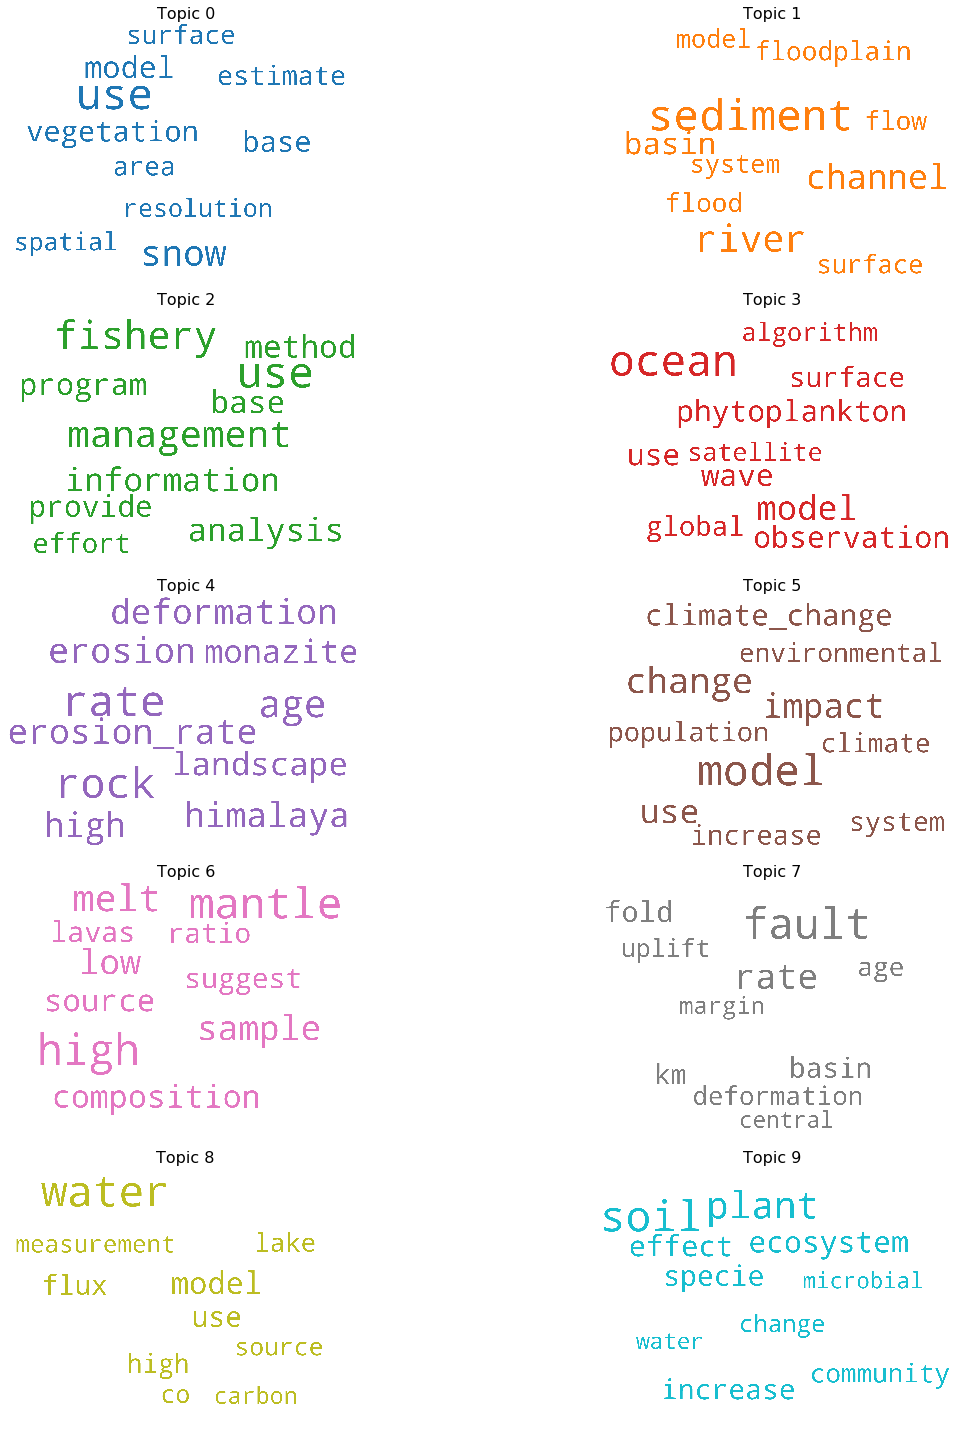

In [393]:
# VISUALIZATION (LDA), Gensim - Wordcloud of top N words in each topic
# TO DO: figure out why different 10 topics used when re-run
# TO DO: visualize all topic wordclouds (if useful)
# TO DO: fix dictionary format and topic numbers
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldagensim.show_topics(formatted=False) #num_topics=-1 shows all; if left empty, pulls X most significant topics
#print(topics) #see tuple structure of topics [(topic), [('keyword', 'weight'), ('keyword', 'weight')...]]

fig, axes = plt.subplots(5, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
#    print(topic_words)
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16)) #topic numbers are incorrect (instead check print(topics) and print(topic_words))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
#plt.savefig('LDA-gensim-14-word-clouds-V1.png') #exports graphic

In [402]:
# VISUALIZATION (LDA), Gensim - t-SNE clustering chart
# Get topic weights and dominant topics
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(ldagensim[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 14
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3510 samples in 0.001s...
[t-SNE] Computed neighbors for 3510 samples in 0.071s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3510
[t-SNE] Computed conditional probabilities for sample 2000 / 3510
[t-SNE] Computed conditional probabilities for sample 3000 / 3510
[t-SNE] Computed conditional probabilities for sample 3510 / 3510
[t-SNE] Mean sigma: 0.002185
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.664536
[t-SNE] KL divergence after 1000 iterations: 0.798016


Loading BokehJS ...

In [406]:
# VISUALIZATION (LDA), MALLET and Gensim, Compare LDA models (of same topic size, 47) from both models
# Define functions to plot the differences in words between models
def plot_difference_plotly(mdiff, title="", annotation=None):
    """Plot the difference between models.

    Uses plotly as the backend."""
    import plotly.graph_objs as go
    import plotly.offline as py

    annotation_html = None
    if annotation is not None:
        annotation_html = [
            [
                "+++ {}<br>--- {}".format(", ".join(int_tokens), ", ".join(diff_tokens))
                for (int_tokens, diff_tokens) in row
            ]
            for row in annotation
        ]

    data = go.Heatmap(z=mdiff, colorscale='RdBu', text=annotation_html)
    layout = go.Layout(width=950, height=950, title=title, xaxis=dict(title="topic"), yaxis=dict(title="topic"))
    py.iplot(dict(data=[data], layout=layout))


def plot_difference_matplotlib(mdiff, title="", annotation=None):
    """Helper function to plot difference between models.

    Uses matplotlib as the backend."""
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(18, 14))
    data = ax.imshow(mdiff, cmap='RdBu_r', origin='lower')
    plt.title(title)
    plt.colorbar(data)


try:
    get_ipython()
    import plotly.offline as py
except Exception:
    #
    # Fall back to matplotlib if we're not in a notebook, or if plotly is
    # unavailable for whatever reason.
    #
    plot_difference = plot_difference_matplotlib
else:
    py.init_notebook_mode()
    plot_difference = plot_difference_plotly

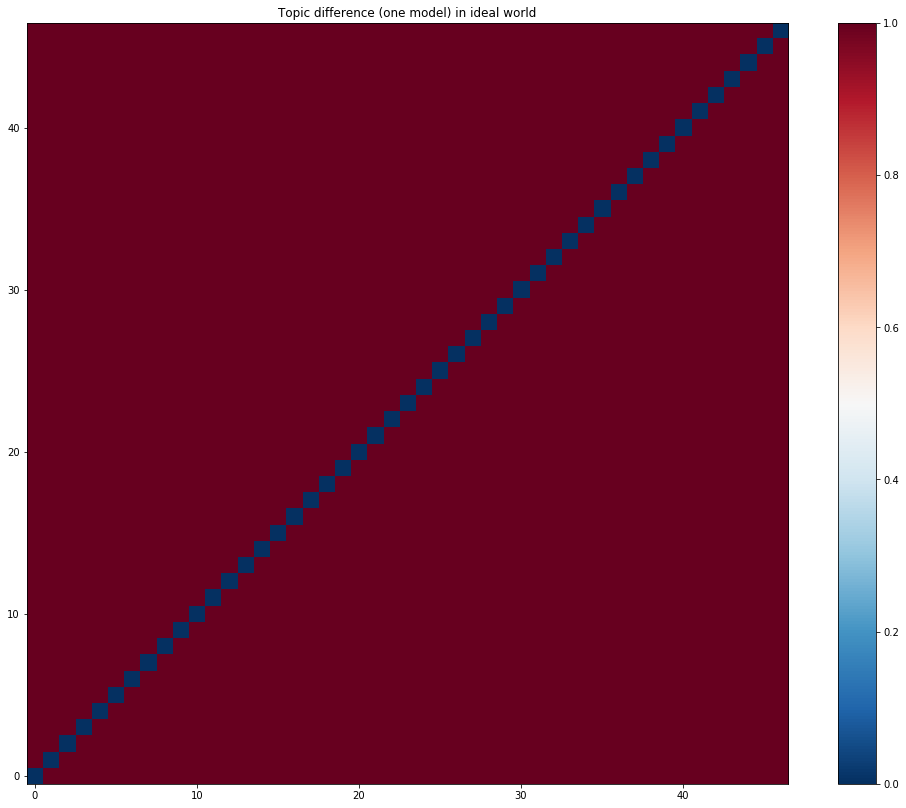

In [409]:
# VISUALIZATION (LDA), MALLET and Gensim, "Ideal" scenario for topic difference across models
#ldagensim (47 topic Gensim)
#model (47 topic MALLET, converted)
num_topics = 47

mdiff = np.ones((num_topics, num_topics))
np.fill_diagonal(mdiff, 0.)
plot_difference(mdiff, title="Topic difference (one model) in ideal world")

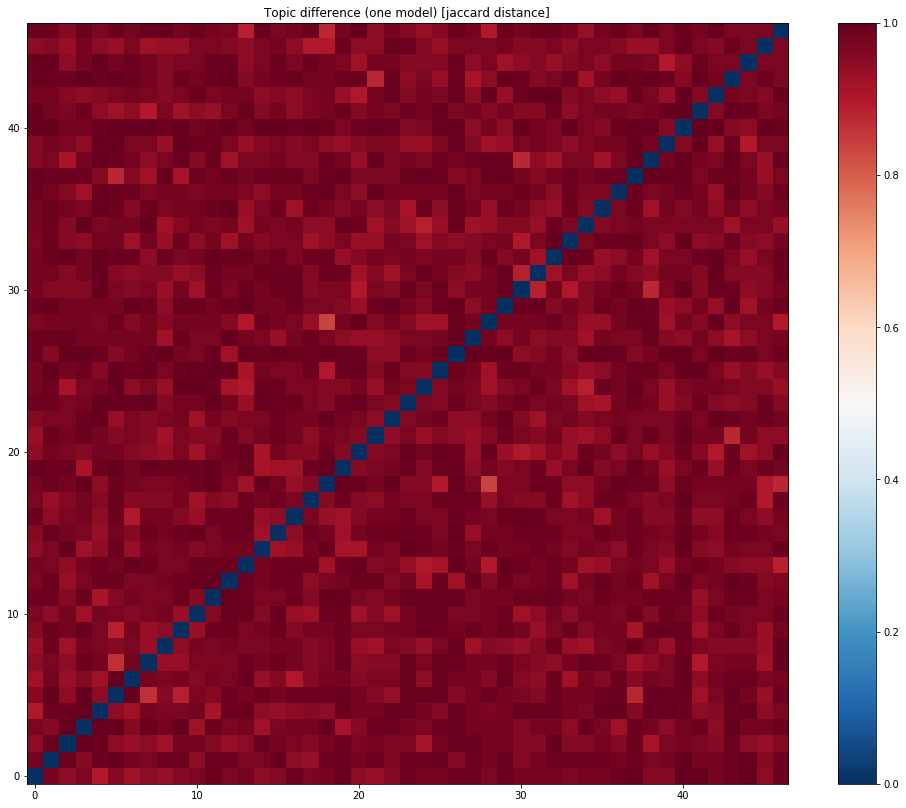

In [415]:
# VISUALIZATION (LDA), MALLET and Gensim, Comparing one model with itself
#ldagensim (47 topic Gensim)
#model (47 topic MALLET, converted)
mdiff, annotation = model.diff(model, distance='jaccard', num_words=50) #distance='hellinger'
plot_difference(mdiff, title="Topic difference (one model) [jaccard distance]", annotation=annotation)

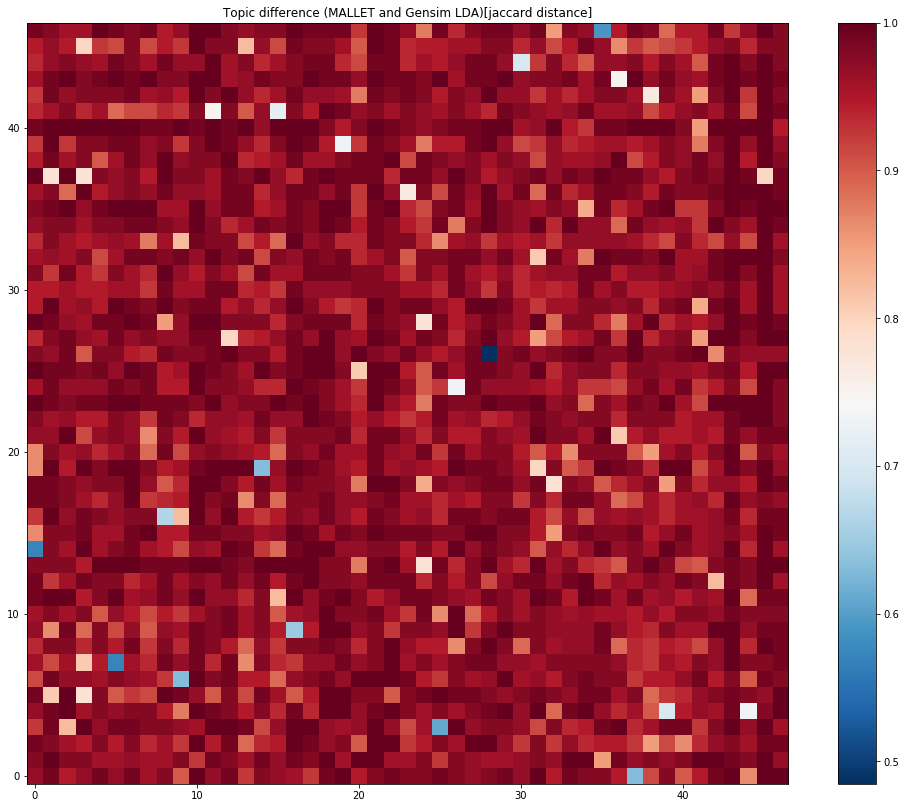

In [426]:
# VISUALIZATION (LDA), MALLET and Gensim, How topics from different models correlate with each other
#ldagensim (47 topic Gensim)
#model (47 topic MALLET, converted)
mdiff, annotation = model.diff(ldagensim, distance='jaccard', num_words=50) #distance='hellinger'
plot_difference(mdiff, title="Topic difference (MALLET and Gensim LDA)[jaccard distance]", annotation=annotation)
#plt.savefig('LDA-comparison-47-dif-corr-V1.png') #exports graphic

In [467]:
# Experimenting with other models (LSI)
# LSI ranks topics by itself and outputs topics in ranked order; requires num_topics to be defined
lsimodel = gensim.models.LsiModel(corpus=corpus, num_topics=5, id2word=id2word) # Trying 10 topics as default
lsimodel.show_topics() 
lsitopics = lsimodel.print_topics()
#len(lsitopics)
pprint(lsitopics)
lsi_coherence = CoherenceModel(model=lsimodel,texts=texts,dictionary=id2word,coherence='c_v').get_coherence()
print(lsi_coherence)

[(0,
  '0.343*"model" + 0.314*"use" + 0.198*"water" + 0.159*"high" + 0.157*"change" '
  '+ 0.141*"result" + 0.126*"increase" + 0.112*"specie" + 0.109*"base" + '
  '0.105*"scale"'),
 (1,
  '0.740*"model" + -0.223*"water" + -0.196*"soil" + -0.161*"increase" + '
  '-0.155*"plant" + -0.136*"change" + -0.135*"specie" + -0.126*"ecosystem" + '
  '-0.103*"high" + -0.094*"effect"'),
 (2,
  '-0.708*"water" + 0.334*"specie" + -0.169*"snow" + 0.138*"effect" + '
  '-0.136*"use" + -0.122*"surface" + 0.121*"plant" + 0.115*"population" + '
  '0.113*"model" + 0.105*"change"'),
 (3,
  '-0.379*"water" + -0.246*"model" + 0.202*"fault" + 0.197*"high" + '
  '-0.172*"specie" + 0.165*"sediment" + -0.159*"soil" + -0.144*"ecosystem" + '
  '0.144*"rate" + 0.142*"sample"'),
 (4,
  '0.485*"use" + 0.269*"specie" + -0.255*"model" + -0.251*"soil" + '
  '-0.216*"change" + -0.192*"climate" + -0.135*"rate" + 0.128*"method" + '
  '0.110*"base" + 0.108*"approach"')]
0.41442994212068546


In [468]:
# Experimenting with other models (HDP)
# Fully unsupervised; determines the best number of topics through "posterior inference"
# Can be used to find hyperparameters for LDA model with hdp_to_lda()
# Can be used to get the term topic matrix learned during inference with get_topics()
hdpmodel = gensim.models.HdpModel(corpus=corpus, id2word=id2word)
hdp_topics = hdpmodel.print_topics()
# len(hdp_topics)
pprint(hdp_topics)
hdp_coherence = CoherenceModel(model=hdpmodel,texts=texts,dictionary=id2word,coherence='c_v').get_coherence()
print(hdp_coherence)

[(0,
  '0.008*model + 0.008*use + 0.005*water + 0.005*high + 0.004*change + '
  '0.004*result + 0.004*increase + 0.003*scale + 0.003*system + 0.003*process'),
 (1,
  '0.010*use + 0.008*model + 0.005*water + 0.004*high + 0.004*result + '
  '0.004*base + 0.004*change + 0.003*surface + 0.003*increase + 0.003*effect'),
 (2,
  '0.008*model + 0.007*use + 0.003*high + 0.003*system + 0.003*water + '
  '0.003*surface + 0.003*snow + 0.003*result + 0.003*change + 0.002*provide'),
 (3,
  '0.007*use + 0.006*model + 0.005*water + 0.004*specie + 0.004*increase + '
  '0.004*change + 0.004*high + 0.003*result + 0.003*effect + 0.003*ecosystem'),
 (4,
  '0.005*use + 0.005*model + 0.004*soil + 0.004*high + 0.003*increase + '
  '0.003*specie + 0.003*result + 0.003*low + 0.003*base + 0.002*water'),
 (5,
  '0.004*model + 0.004*use + 0.003*high + 0.003*water + 0.003*result + '
  '0.002*change + 0.002*surface + 0.002*area + 0.002*rate + 0.002*time'),
 (6,
  '0.004*use + 0.003*water + 0.003*high + 0.003*model +

In [ ]:
# TO DO: evaluate all topic models by plugging them into a 'coherence pipeline'
# LDA (Mallet)
# LDA (Gensim)
# LSI (Gensim)
# HDP (Gensim)
# hLDA (Mallet)
# NMF (Sckit-learn)